# Pretrained model weights are not frozen it changes during training
 unless  explicitly set them to requires_grad=False
 
 #Freeze the pretrained layers
        for param in self.convnet.parameters():
            param.requires_grad = False

import os
import random
import shutil

def split_images(image_dir, train_dir, valid_dir, validation_percentage=20):
    # Create train and validation directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)

    # Collect all .tiff files from all subdirectories
    image_files = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.tiff', 'tiff')):
                image_files.append(os.path.join(root, file))

    # Shuffle the files randomly
    random.shuffle(image_files)

    # Split the images into training and validation sets
    total_images = len(image_files)
    validation_count = int(total_images * validation_percentage / 100)

    validation_files = image_files[:validation_count]
    training_files = image_files[validation_count:]

    # Move files to train and validation directories
    for file_path in training_files:
        destination = os.path.join(train_dir, os.path.basename(file_path))
        shutil.copy(file_path, destination)

    for file_path in validation_files:
        destination = os.path.join(valid_dir, os.path.basename(file_path))
        shutil.copy(file_path, destination)

    print(f"Total images: {total_images}")
    print(f"Training images: {len(training_files)}")
    print(f"Validation images: {len(validation_files)}")

# Example usage
image_dir = r"../../tiff_experiment_unsupervised_data/combined"
train_dir = r"../../tiff_experiment_unsupervised_data/train"
valid_dir = r"../../tiff_experiment_unsupervised_data/validation"

split_images(image_dir, train_dir, valid_dir, validation_percentage=20)


In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
#from helper import set_seed

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use the `device` variable
print(f"Using device: {device}")

Using device: cuda


In [3]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [4]:
# Define file paths
model_path = r'C:\Users\k54739\saved_model\ohneContrastSweetcrop_simclr_model_epoch_245.pth'

In [5]:
# Reinitialize the model
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(model_path))
simclr_model.to(device)
simclr_model.eval()
# Load the metrics
#loaded_metrics = torch.load(metrics_path)


C:\Users\k54739\AppData\Local\Temp\ipykernel_17840\2711482870.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Inference before projection head

# Logistic

In [6]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.metrics import accuracy_score

In [7]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    
    classes = ['cond7_all', 'sd','ex']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\classification"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [8]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0])


In [9]:
# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in train_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in train_loader_labeled: {total_images}")


Total number of images in train_loader_labeled: 492


In [10]:
# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in test_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in test_loader_labeled: {total_images}")


Total number of images in test_loader_labeled: 123


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [13]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

  3%|▎         | 1/31 [00:01<00:30,  1.01s/it]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


  6%|▋         | 2/31 [00:01<00:25,  1.15it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 10%|▉         | 3/31 [00:02<00:22,  1.24it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 13%|█▎        | 4/31 [00:03<00:21,  1.27it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 16%|█▌        | 5/31 [00:04<00:20,  1.28it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 19%|█▉        | 6/31 [00:04<00:19,  1.28it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 23%|██▎       | 7/31 [00:05<00:18,  1.29it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 26%|██▌       | 8/31 [00:06<00:17,  1.31it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 29%|██▉       | 9/31 [00:07<00:16,  1.32it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 32%|███▏      | 10/31 [00:07<00:15,  1.32it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 35%|███▌      | 11/31 [00:08<00:15,  1.32it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 39%|███▊      | 12/31 [00:09<00:14,  1.31it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 42%|████▏     | 13/31 [00:10<00:13,  1.32it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 45%|████▌     | 14/31 [00:10<00:12,  1.32it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 48%|████▊     | 15/31 [00:11<00:12,  1.31it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 52%|█████▏    | 16/31 [00:12<00:11,  1.30it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 55%|█████▍    | 17/31 [00:13<00:11,  1.27it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 58%|█████▊    | 18/31 [00:14<00:10,  1.28it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 61%|██████▏   | 19/31 [00:14<00:09,  1.31it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 65%|██████▍   | 20/31 [00:15<00:08,  1.31it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 68%|██████▊   | 21/31 [00:16<00:07,  1.29it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 71%|███████   | 22/31 [00:17<00:07,  1.26it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 74%|███████▍  | 23/31 [00:17<00:06,  1.28it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 77%|███████▋  | 24/31 [00:18<00:05,  1.26it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 81%|████████  | 25/31 [00:19<00:04,  1.21it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 84%|████████▍ | 26/31 [00:20<00:04,  1.24it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 87%|████████▋ | 27/31 [00:21<00:03,  1.25it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 90%|█████████ | 28/31 [00:22<00:02,  1.22it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 94%|█████████▎| 29/31 [00:22<00:01,  1.20it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 97%|█████████▋| 30/31 [00:23<00:00,  1.16it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


100%|██████████| 31/31 [00:24<00:00,  1.27it/s]


Batch features shape: torch.Size([12, 20])
Batch labels shape: torch.Size([12])
Features shape after concatenation: torch.Size([492, 20])
Labels shape after concatenation: torch.Size([492])


 12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 25%|██▌       | 2/8 [00:01<00:04,  1.22it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 50%|█████     | 4/8 [00:03<00:03,  1.19it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 62%|██████▎   | 5/8 [00:04<00:02,  1.20it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 6/8 [00:04<00:01,  1.20it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 88%|████████▊ | 7/8 [00:05<00:00,  1.19it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]

Batch features shape: torch.Size([11, 20])
Batch labels shape: torch.Size([11])
Features shape after concatenation: torch.Size([123, 20])
Labels shape after concatenation: torch.Size([123])


In [14]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [15]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [16]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [17]:
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                              drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                             drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Track best by accuracy
    best_test_acc = -1.0
    best_model_state_acc = None

    # Track best by loss (with accuracy as a tiebreaker)
    best_test_loss = float('inf')
    best_test_loss_acc = -1.0
    best_model_state_loss = None

    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)

        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Check for best accuracy model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state_acc = model.state_dict()

        # Check for best loss model
        # Condition: strictly lower loss OR equal loss but higher accuracy
        if (test_loss < best_test_loss) or (test_loss == best_test_loss and test_acc > best_test_loss_acc):
            best_test_loss = test_loss
            best_test_loss_acc = test_acc
            best_model_state_loss = model.state_dict()

    # Now we have two best states: best_model_state_acc and best_model_state_loss
    # Create two separate model instances for them
    best_acc_model = LogisticRegression(feature_dim, num_classes).to(device)
    best_acc_model.load_state_dict(best_model_state_acc)
    best_acc_model.eval()

    best_loss_model = LogisticRegression(feature_dim, num_classes).to(device)
    best_loss_model.load_state_dict(best_model_state_loss)
    best_loss_model.eval()

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return both models and the final results (e.g., last train_acc and test_acc recorded)
    return best_acc_model, best_loss_model, {"train_acc": train_acc, "test_acc": test_acc}


Epoch 1/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 233.02it/s]


Training loss: 1.3565, Training accuracy: 0.3476
Test loss: 1.2936, Test accuracy: 0.3577
Epoch 2/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 246.94it/s]


Training loss: 1.2386, Training accuracy: 0.3963
Test loss: 1.1897, Test accuracy: 0.4228
Epoch 3/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 244.22it/s]


Training loss: 1.1515, Training accuracy: 0.4309
Test loss: 1.1449, Test accuracy: 0.4390
Epoch 4/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 264.61it/s]


Training loss: 1.1367, Training accuracy: 0.4329
Test loss: 1.1420, Test accuracy: 0.4390
Epoch 5/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 314.23it/s]


Training loss: 1.1286, Training accuracy: 0.4329
Test loss: 1.1410, Test accuracy: 0.4390
Epoch 6/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 246.64it/s]


Training loss: 1.1314, Training accuracy: 0.4329
Test loss: 1.1401, Test accuracy: 0.4390
Epoch 7/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 248.54it/s]


Training loss: 1.1362, Training accuracy: 0.4350
Test loss: 1.1391, Test accuracy: 0.4390
Epoch 8/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 211.88it/s]


Training loss: 1.1296, Training accuracy: 0.4350
Test loss: 1.1382, Test accuracy: 0.4390
Epoch 9/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 317.26it/s]


Training loss: 1.1379, Training accuracy: 0.4350
Test loss: 1.1372, Test accuracy: 0.4390
Epoch 10/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 251.74it/s]


Training loss: 1.1287, Training accuracy: 0.4350
Test loss: 1.1363, Test accuracy: 0.4390
Epoch 11/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 242.87it/s]


Training loss: 1.1267, Training accuracy: 0.4370
Test loss: 1.1353, Test accuracy: 0.4390
Epoch 12/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 235.85it/s]


Training loss: 1.1257, Training accuracy: 0.4370
Test loss: 1.1343, Test accuracy: 0.4390
Epoch 13/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 244.60it/s]


Training loss: 1.1311, Training accuracy: 0.4370
Test loss: 1.1334, Test accuracy: 0.4390
Epoch 14/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 333.77it/s]


Training loss: 1.1222, Training accuracy: 0.4370
Test loss: 1.1324, Test accuracy: 0.4390
Epoch 15/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 217.51it/s]


Training loss: 1.1246, Training accuracy: 0.4390
Test loss: 1.1315, Test accuracy: 0.4390
Epoch 16/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 247.41it/s]


Training loss: 1.1199, Training accuracy: 0.4390
Test loss: 1.1305, Test accuracy: 0.4472
Epoch 17/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 206.14it/s]


Training loss: 1.1221, Training accuracy: 0.4411
Test loss: 1.1296, Test accuracy: 0.4472
Epoch 18/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 226.40it/s]


Training loss: 1.1261, Training accuracy: 0.4431
Test loss: 1.1287, Test accuracy: 0.4472
Epoch 19/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 237.65it/s]


Training loss: 1.1278, Training accuracy: 0.4431
Test loss: 1.1277, Test accuracy: 0.4472
Epoch 20/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 314.67it/s]


Training loss: 1.1159, Training accuracy: 0.4451
Test loss: 1.1267, Test accuracy: 0.4472
Epoch 21/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 319.82it/s]


Training loss: 1.1195, Training accuracy: 0.4451
Test loss: 1.1258, Test accuracy: 0.4472
Epoch 22/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 235.43it/s]


Training loss: 1.1155, Training accuracy: 0.4451
Test loss: 1.1248, Test accuracy: 0.4472
Epoch 23/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 202.48it/s]


Training loss: 1.1147, Training accuracy: 0.4472
Test loss: 1.1239, Test accuracy: 0.4472
Epoch 24/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 219.29it/s]


Training loss: 1.1196, Training accuracy: 0.4472
Test loss: 1.1230, Test accuracy: 0.4472
Epoch 25/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 244.53it/s]


Training loss: 1.1158, Training accuracy: 0.4492
Test loss: 1.1220, Test accuracy: 0.4472
Epoch 26/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 245.99it/s]


Training loss: 1.1141, Training accuracy: 0.4492
Test loss: 1.1211, Test accuracy: 0.4472
Epoch 27/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 306.44it/s]


Training loss: 1.1147, Training accuracy: 0.4492
Test loss: 1.1201, Test accuracy: 0.4472
Epoch 28/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 242.78it/s]


Training loss: 1.1136, Training accuracy: 0.4492
Test loss: 1.1192, Test accuracy: 0.4472
Epoch 29/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 355.99it/s]


Training loss: 1.1148, Training accuracy: 0.4492
Test loss: 1.1182, Test accuracy: 0.4472
Epoch 30/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 238.16it/s]


Training loss: 1.1054, Training accuracy: 0.4492
Test loss: 1.1173, Test accuracy: 0.4472
Epoch 31/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 310.34it/s]


Training loss: 1.1101, Training accuracy: 0.4492
Test loss: 1.1164, Test accuracy: 0.4472
Epoch 32/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 246.80it/s]


Training loss: 1.1089, Training accuracy: 0.4492
Test loss: 1.1154, Test accuracy: 0.4472
Epoch 33/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 225.01it/s]


Training loss: 1.1037, Training accuracy: 0.4512
Test loss: 1.1145, Test accuracy: 0.4472
Epoch 34/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 208.39it/s]


Training loss: 1.1099, Training accuracy: 0.4533
Test loss: 1.1135, Test accuracy: 0.4472
Epoch 35/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 216.80it/s]


Training loss: 1.1016, Training accuracy: 0.4533
Test loss: 1.1126, Test accuracy: 0.4472
Epoch 36/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 235.96it/s]


Training loss: 1.1047, Training accuracy: 0.4533
Test loss: 1.1117, Test accuracy: 0.4472
Epoch 37/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 236.98it/s]


Training loss: 1.1016, Training accuracy: 0.4533
Test loss: 1.1108, Test accuracy: 0.4472
Epoch 38/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 244.49it/s]


Training loss: 1.0979, Training accuracy: 0.4533
Test loss: 1.1098, Test accuracy: 0.4472
Epoch 39/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 213.21it/s]


Training loss: 1.1060, Training accuracy: 0.4533
Test loss: 1.1089, Test accuracy: 0.4472
Epoch 40/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 263.46it/s]


Training loss: 1.1034, Training accuracy: 0.4553
Test loss: 1.1079, Test accuracy: 0.4472
Epoch 41/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 313.36it/s]


Training loss: 1.1000, Training accuracy: 0.4553
Test loss: 1.1070, Test accuracy: 0.4472
Epoch 42/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 236.47it/s]


Training loss: 1.0998, Training accuracy: 0.4553
Test loss: 1.1061, Test accuracy: 0.4472
Epoch 43/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 335.39it/s]


Training loss: 1.0944, Training accuracy: 0.4553
Test loss: 1.1052, Test accuracy: 0.4472
Epoch 44/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 242.94it/s]


Training loss: 1.1019, Training accuracy: 0.4573
Test loss: 1.1042, Test accuracy: 0.4472
Epoch 45/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 316.20it/s]


Training loss: 1.0930, Training accuracy: 0.4573
Test loss: 1.1033, Test accuracy: 0.4472
Epoch 46/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 267.48it/s]


Training loss: 1.0937, Training accuracy: 0.4573
Test loss: 1.1024, Test accuracy: 0.4472
Epoch 47/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 232.29it/s]


Training loss: 1.0922, Training accuracy: 0.4573
Test loss: 1.1015, Test accuracy: 0.4472
Epoch 48/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 277.42it/s]


Training loss: 1.0933, Training accuracy: 0.4593
Test loss: 1.1006, Test accuracy: 0.4472
Epoch 49/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 224.76it/s]


Training loss: 1.0911, Training accuracy: 0.4593
Test loss: 1.0996, Test accuracy: 0.4472
Epoch 50/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 231.25it/s]


Training loss: 1.0890, Training accuracy: 0.4593
Test loss: 1.0987, Test accuracy: 0.4472
Epoch 51/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 260.32it/s]


Training loss: 1.0880, Training accuracy: 0.4614
Test loss: 1.0978, Test accuracy: 0.4553
Epoch 52/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 202.75it/s]


Training loss: 1.0859, Training accuracy: 0.4614
Test loss: 1.0969, Test accuracy: 0.4553
Epoch 53/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 306.49it/s]


Training loss: 1.0891, Training accuracy: 0.4654
Test loss: 1.0959, Test accuracy: 0.4553
Epoch 54/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 270.47it/s]


Training loss: 1.0854, Training accuracy: 0.4654
Test loss: 1.0950, Test accuracy: 0.4553
Epoch 55/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 224.12it/s]


Training loss: 1.0899, Training accuracy: 0.4654
Test loss: 1.0941, Test accuracy: 0.4553
Epoch 56/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 226.15it/s]


Training loss: 1.0807, Training accuracy: 0.4654
Test loss: 1.0932, Test accuracy: 0.4553
Epoch 57/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 218.81it/s]


Training loss: 1.0821, Training accuracy: 0.4654
Test loss: 1.0922, Test accuracy: 0.4472
Epoch 58/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 221.17it/s]


Training loss: 1.0784, Training accuracy: 0.4654
Test loss: 1.0914, Test accuracy: 0.4472
Epoch 59/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 218.89it/s]


Training loss: 1.0822, Training accuracy: 0.4675
Test loss: 1.0905, Test accuracy: 0.4472
Epoch 60/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 219.57it/s]


Training loss: 1.0843, Training accuracy: 0.4675
Test loss: 1.0895, Test accuracy: 0.4472
Epoch 61/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 227.74it/s]


Training loss: 1.0799, Training accuracy: 0.4675
Test loss: 1.0886, Test accuracy: 0.4472
Epoch 62/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 308.29it/s]


Training loss: 1.0803, Training accuracy: 0.4675
Test loss: 1.0877, Test accuracy: 0.4472
Epoch 63/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 192.33it/s]


Training loss: 1.0819, Training accuracy: 0.4675
Test loss: 1.0868, Test accuracy: 0.4472
Epoch 64/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 311.19it/s]


Training loss: 1.0764, Training accuracy: 0.4695
Test loss: 1.0859, Test accuracy: 0.4472
Epoch 65/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 356.55it/s]


Training loss: 1.0740, Training accuracy: 0.4715
Test loss: 1.0850, Test accuracy: 0.4472
Epoch 66/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 231.73it/s]


Training loss: 1.0825, Training accuracy: 0.4715
Test loss: 1.0841, Test accuracy: 0.4472
Epoch 67/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 313.66it/s]


Training loss: 1.0743, Training accuracy: 0.4715
Test loss: 1.0832, Test accuracy: 0.4472
Epoch 68/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 200.20it/s]


Training loss: 1.0708, Training accuracy: 0.4715
Test loss: 1.0823, Test accuracy: 0.4472
Epoch 69/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 231.74it/s]


Training loss: 1.0778, Training accuracy: 0.4715
Test loss: 1.0814, Test accuracy: 0.4472
Epoch 70/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 243.62it/s]


Training loss: 1.0729, Training accuracy: 0.4715
Test loss: 1.0805, Test accuracy: 0.4472
Epoch 71/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 210.21it/s]


Training loss: 1.0731, Training accuracy: 0.4736
Test loss: 1.0796, Test accuracy: 0.4472
Epoch 72/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 308.23it/s]


Training loss: 1.0697, Training accuracy: 0.4736
Test loss: 1.0787, Test accuracy: 0.4472
Epoch 73/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 260.95it/s]


Training loss: 1.0720, Training accuracy: 0.4736
Test loss: 1.0778, Test accuracy: 0.4472
Epoch 74/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 220.66it/s]


Training loss: 1.0646, Training accuracy: 0.4736
Test loss: 1.0769, Test accuracy: 0.4472
Epoch 75/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 225.56it/s]


Training loss: 1.0658, Training accuracy: 0.4736
Test loss: 1.0760, Test accuracy: 0.4472
Epoch 76/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 225.89it/s]


Training loss: 1.0665, Training accuracy: 0.4756
Test loss: 1.0751, Test accuracy: 0.4472
Epoch 77/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 322.15it/s]


Training loss: 1.0617, Training accuracy: 0.4756
Test loss: 1.0742, Test accuracy: 0.4472
Epoch 78/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 317.25it/s]


Training loss: 1.0671, Training accuracy: 0.4756
Test loss: 1.0733, Test accuracy: 0.4472
Epoch 79/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 214.90it/s]


Training loss: 1.0675, Training accuracy: 0.4756
Test loss: 1.0724, Test accuracy: 0.4472
Epoch 80/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 228.19it/s]


Training loss: 1.0598, Training accuracy: 0.4756
Test loss: 1.0715, Test accuracy: 0.4472
Epoch 81/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 250.07it/s]


Training loss: 1.0650, Training accuracy: 0.4756
Test loss: 1.0707, Test accuracy: 0.4472
Epoch 82/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 297.75it/s]


Training loss: 1.0607, Training accuracy: 0.4756
Test loss: 1.0698, Test accuracy: 0.4472
Epoch 83/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 250.39it/s]


Training loss: 1.0599, Training accuracy: 0.4756
Test loss: 1.0689, Test accuracy: 0.4472
Epoch 84/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 209.87it/s]


Training loss: 1.0668, Training accuracy: 0.4756
Test loss: 1.0680, Test accuracy: 0.4472
Epoch 85/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 217.31it/s]


Training loss: 1.0619, Training accuracy: 0.4756
Test loss: 1.0671, Test accuracy: 0.4472
Epoch 86/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 268.46it/s]


Training loss: 1.0598, Training accuracy: 0.4756
Test loss: 1.0662, Test accuracy: 0.4472
Epoch 87/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 223.63it/s]


Training loss: 1.0546, Training accuracy: 0.4776
Test loss: 1.0653, Test accuracy: 0.4472
Epoch 88/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 318.26it/s]


Training loss: 1.0571, Training accuracy: 0.4776
Test loss: 1.0645, Test accuracy: 0.4472
Epoch 89/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 241.62it/s]


Training loss: 1.0555, Training accuracy: 0.4776
Test loss: 1.0636, Test accuracy: 0.4472
Epoch 90/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 233.33it/s]


Training loss: 1.0549, Training accuracy: 0.4797
Test loss: 1.0627, Test accuracy: 0.4472
Epoch 91/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 311.97it/s]


Training loss: 1.0544, Training accuracy: 0.4797
Test loss: 1.0618, Test accuracy: 0.4553
Epoch 92/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 237.47it/s]


Training loss: 1.0592, Training accuracy: 0.4797
Test loss: 1.0609, Test accuracy: 0.4553
Epoch 93/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 241.78it/s]


Training loss: 1.0480, Training accuracy: 0.4797
Test loss: 1.0600, Test accuracy: 0.4553
Epoch 94/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 232.18it/s]


Training loss: 1.0515, Training accuracy: 0.4817
Test loss: 1.0592, Test accuracy: 0.4553
Epoch 95/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 239.15it/s]


Training loss: 1.0536, Training accuracy: 0.4817
Test loss: 1.0583, Test accuracy: 0.4553
Epoch 96/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 213.81it/s]


Training loss: 1.0570, Training accuracy: 0.4837
Test loss: 1.0574, Test accuracy: 0.4553
Epoch 97/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 231.79it/s]


Training loss: 1.0479, Training accuracy: 0.4858
Test loss: 1.0565, Test accuracy: 0.4553
Epoch 98/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 270.91it/s]


Training loss: 1.0545, Training accuracy: 0.4878
Test loss: 1.0556, Test accuracy: 0.4553
Epoch 99/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 249.68it/s]


Training loss: 1.0475, Training accuracy: 0.4878
Test loss: 1.0547, Test accuracy: 0.4634
Epoch 100/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 255.26it/s]


Training loss: 1.0533, Training accuracy: 0.4878
Test loss: 1.0539, Test accuracy: 0.4634
Epoch 101/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 229.13it/s]


Training loss: 1.0456, Training accuracy: 0.4878
Test loss: 1.0530, Test accuracy: 0.4634
Epoch 102/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 210.91it/s]


Training loss: 1.0418, Training accuracy: 0.4878
Test loss: 1.0521, Test accuracy: 0.4634
Epoch 103/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 219.94it/s]


Training loss: 1.0402, Training accuracy: 0.4878
Test loss: 1.0513, Test accuracy: 0.4634
Epoch 104/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 239.01it/s]


Training loss: 1.0422, Training accuracy: 0.4878
Test loss: 1.0504, Test accuracy: 0.4634
Epoch 105/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 256.94it/s]


Training loss: 1.0441, Training accuracy: 0.4878
Test loss: 1.0495, Test accuracy: 0.4634
Epoch 106/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 236.07it/s]


Training loss: 1.0381, Training accuracy: 0.4878
Test loss: 1.0487, Test accuracy: 0.4634
Epoch 107/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 269.18it/s]


Training loss: 1.0376, Training accuracy: 0.4898
Test loss: 1.0478, Test accuracy: 0.4715
Epoch 108/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 256.44it/s]


Training loss: 1.0440, Training accuracy: 0.4898
Test loss: 1.0469, Test accuracy: 0.4715
Epoch 109/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 303.71it/s]


Training loss: 1.0375, Training accuracy: 0.4898
Test loss: 1.0461, Test accuracy: 0.4715
Epoch 110/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 234.90it/s]


Training loss: 1.0361, Training accuracy: 0.4898
Test loss: 1.0452, Test accuracy: 0.4715
Epoch 111/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 245.71it/s]


Training loss: 1.0352, Training accuracy: 0.4919
Test loss: 1.0443, Test accuracy: 0.4715
Epoch 112/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 232.08it/s]


Training loss: 1.0359, Training accuracy: 0.4919
Test loss: 1.0435, Test accuracy: 0.4715
Epoch 113/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 246.92it/s]


Training loss: 1.0353, Training accuracy: 0.4939
Test loss: 1.0426, Test accuracy: 0.4715
Epoch 114/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 202.18it/s]


Training loss: 1.0340, Training accuracy: 0.4959
Test loss: 1.0418, Test accuracy: 0.4715
Epoch 115/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 231.90it/s]


Training loss: 1.0323, Training accuracy: 0.4959
Test loss: 1.0409, Test accuracy: 0.4715
Epoch 116/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 264.42it/s]


Training loss: 1.0293, Training accuracy: 0.4959
Test loss: 1.0400, Test accuracy: 0.4715
Epoch 117/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 312.99it/s]


Training loss: 1.0297, Training accuracy: 0.4959
Test loss: 1.0392, Test accuracy: 0.4715
Epoch 118/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 220.08it/s]


Training loss: 1.0284, Training accuracy: 0.4959
Test loss: 1.0383, Test accuracy: 0.4797
Epoch 119/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 258.54it/s]


Training loss: 1.0317, Training accuracy: 0.4959
Test loss: 1.0375, Test accuracy: 0.4797
Epoch 120/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 265.06it/s]


Training loss: 1.0270, Training accuracy: 0.4980
Test loss: 1.0366, Test accuracy: 0.4797
Epoch 121/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 232.65it/s]


Training loss: 1.0298, Training accuracy: 0.4980
Test loss: 1.0358, Test accuracy: 0.4797
Epoch 122/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 289.32it/s]


Training loss: 1.0220, Training accuracy: 0.4980
Test loss: 1.0349, Test accuracy: 0.4797
Epoch 123/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 242.29it/s]


Training loss: 1.0218, Training accuracy: 0.4980
Test loss: 1.0341, Test accuracy: 0.4797
Epoch 124/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 301.63it/s]


Training loss: 1.0223, Training accuracy: 0.4980
Test loss: 1.0333, Test accuracy: 0.4797
Epoch 125/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 238.80it/s]


Training loss: 1.0261, Training accuracy: 0.4980
Test loss: 1.0324, Test accuracy: 0.4797
Epoch 126/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 263.33it/s]


Training loss: 1.0198, Training accuracy: 0.4980
Test loss: 1.0315, Test accuracy: 0.4797
Epoch 127/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 277.87it/s]


Training loss: 1.0231, Training accuracy: 0.4980
Test loss: 1.0307, Test accuracy: 0.4797
Epoch 128/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 230.98it/s]


Training loss: 1.0228, Training accuracy: 0.5000
Test loss: 1.0299, Test accuracy: 0.4797
Epoch 129/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 251.86it/s]


Training loss: 1.0214, Training accuracy: 0.5000
Test loss: 1.0290, Test accuracy: 0.4797
Epoch 130/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 320.48it/s]


Training loss: 1.0260, Training accuracy: 0.5020
Test loss: 1.0282, Test accuracy: 0.4797
Epoch 131/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 247.45it/s]


Training loss: 1.0187, Training accuracy: 0.5020
Test loss: 1.0273, Test accuracy: 0.4797
Epoch 132/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 220.55it/s]


Training loss: 1.0283, Training accuracy: 0.5020
Test loss: 1.0265, Test accuracy: 0.4797
Epoch 133/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 229.69it/s]


Training loss: 1.0172, Training accuracy: 0.5041
Test loss: 1.0257, Test accuracy: 0.4797
Epoch 134/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 245.60it/s]


Training loss: 1.0185, Training accuracy: 0.5041
Test loss: 1.0248, Test accuracy: 0.4797
Epoch 135/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 247.28it/s]


Training loss: 1.0157, Training accuracy: 0.5041
Test loss: 1.0240, Test accuracy: 0.4797
Epoch 136/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 234.25it/s]


Training loss: 1.0198, Training accuracy: 0.5041
Test loss: 1.0231, Test accuracy: 0.4797
Epoch 137/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 257.12it/s]


Training loss: 1.0132, Training accuracy: 0.5041
Test loss: 1.0223, Test accuracy: 0.4797
Epoch 138/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 306.09it/s]


Training loss: 1.0135, Training accuracy: 0.5041
Test loss: 1.0215, Test accuracy: 0.4797
Epoch 139/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 232.13it/s]


Training loss: 1.0131, Training accuracy: 0.5081
Test loss: 1.0206, Test accuracy: 0.4797
Epoch 140/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 213.58it/s]


Training loss: 1.0093, Training accuracy: 0.5081
Test loss: 1.0198, Test accuracy: 0.4797
Epoch 141/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 233.58it/s]


Training loss: 1.0081, Training accuracy: 0.5081
Test loss: 1.0189, Test accuracy: 0.4797
Epoch 142/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 236.96it/s]


Training loss: 1.0068, Training accuracy: 0.5081
Test loss: 1.0181, Test accuracy: 0.4797
Epoch 143/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 247.31it/s]


Training loss: 1.0133, Training accuracy: 0.5081
Test loss: 1.0173, Test accuracy: 0.4797
Epoch 144/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 229.30it/s]


Training loss: 1.0069, Training accuracy: 0.5081
Test loss: 1.0164, Test accuracy: 0.4797
Epoch 145/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 232.56it/s]


Training loss: 1.0079, Training accuracy: 0.5081
Test loss: 1.0156, Test accuracy: 0.4797
Epoch 146/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 296.09it/s]


Training loss: 1.0037, Training accuracy: 0.5081
Test loss: 1.0148, Test accuracy: 0.4797
Epoch 147/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 274.16it/s]


Training loss: 1.0027, Training accuracy: 0.5081
Test loss: 1.0140, Test accuracy: 0.4878
Epoch 148/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 241.49it/s]


Training loss: 1.0050, Training accuracy: 0.5081
Test loss: 1.0132, Test accuracy: 0.4878
Epoch 149/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 233.40it/s]


Training loss: 1.0018, Training accuracy: 0.5081
Test loss: 1.0123, Test accuracy: 0.4878
Epoch 150/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 250.98it/s]


Training loss: 1.0031, Training accuracy: 0.5081
Test loss: 1.0115, Test accuracy: 0.4878
Epoch 151/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 230.55it/s]


Training loss: 1.0012, Training accuracy: 0.5081
Test loss: 1.0107, Test accuracy: 0.4878
Epoch 152/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 242.32it/s]


Training loss: 0.9991, Training accuracy: 0.5081
Test loss: 1.0098, Test accuracy: 0.4797
Epoch 153/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 236.61it/s]


Training loss: 1.0046, Training accuracy: 0.5081
Test loss: 1.0090, Test accuracy: 0.4797
Epoch 154/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 258.80it/s]


Training loss: 1.0064, Training accuracy: 0.5081
Test loss: 1.0082, Test accuracy: 0.4797
Epoch 155/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 307.82it/s]


Training loss: 0.9994, Training accuracy: 0.5081
Test loss: 1.0074, Test accuracy: 0.4797
Epoch 156/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 208.85it/s]


Training loss: 0.9973, Training accuracy: 0.5081
Test loss: 1.0066, Test accuracy: 0.4797
Epoch 157/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 281.59it/s]


Training loss: 0.9976, Training accuracy: 0.5081
Test loss: 1.0058, Test accuracy: 0.4797
Epoch 158/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 254.48it/s]


Training loss: 0.9973, Training accuracy: 0.5081
Test loss: 1.0049, Test accuracy: 0.4797
Epoch 159/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 230.10it/s]


Training loss: 0.9933, Training accuracy: 0.5081
Test loss: 1.0041, Test accuracy: 0.4797
Epoch 160/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 233.83it/s]


Training loss: 0.9939, Training accuracy: 0.5081
Test loss: 1.0033, Test accuracy: 0.4797
Epoch 161/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 270.87it/s]


Training loss: 0.9930, Training accuracy: 0.5081
Test loss: 1.0025, Test accuracy: 0.4797
Epoch 162/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 266.54it/s]


Training loss: 0.9934, Training accuracy: 0.5081
Test loss: 1.0017, Test accuracy: 0.4797
Epoch 163/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 234.97it/s]


Training loss: 0.9902, Training accuracy: 0.5102
Test loss: 1.0009, Test accuracy: 0.4797
Epoch 164/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 226.95it/s]


Training loss: 0.9938, Training accuracy: 0.5102
Test loss: 1.0001, Test accuracy: 0.4797
Epoch 165/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 208.88it/s]


Training loss: 0.9934, Training accuracy: 0.5102
Test loss: 0.9993, Test accuracy: 0.4797
Epoch 166/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 236.06it/s]


Training loss: 0.9865, Training accuracy: 0.5102
Test loss: 0.9984, Test accuracy: 0.4797
Epoch 167/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 327.30it/s]


Training loss: 0.9901, Training accuracy: 0.5102
Test loss: 0.9977, Test accuracy: 0.4797
Epoch 168/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 257.51it/s]


Training loss: 0.9912, Training accuracy: 0.5102
Test loss: 0.9968, Test accuracy: 0.4797
Epoch 169/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 295.03it/s]


Training loss: 0.9903, Training accuracy: 0.5122
Test loss: 0.9960, Test accuracy: 0.4797
Epoch 170/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 263.74it/s]


Training loss: 0.9888, Training accuracy: 0.5122
Test loss: 0.9952, Test accuracy: 0.4797
Epoch 171/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 310.58it/s]


Training loss: 0.9818, Training accuracy: 0.5122
Test loss: 0.9944, Test accuracy: 0.4797
Epoch 172/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 236.30it/s]


Training loss: 0.9867, Training accuracy: 0.5122
Test loss: 0.9936, Test accuracy: 0.4797
Epoch 173/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 303.02it/s]


Training loss: 0.9852, Training accuracy: 0.5122
Test loss: 0.9928, Test accuracy: 0.4797
Epoch 174/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 249.84it/s]


Training loss: 0.9850, Training accuracy: 0.5142
Test loss: 0.9920, Test accuracy: 0.4797
Epoch 175/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 250.26it/s]


Training loss: 0.9797, Training accuracy: 0.5142
Test loss: 0.9912, Test accuracy: 0.4797
Epoch 176/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 269.03it/s]


Training loss: 0.9831, Training accuracy: 0.5142
Test loss: 0.9904, Test accuracy: 0.4797
Epoch 177/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 256.43it/s]


Training loss: 0.9799, Training accuracy: 0.5183
Test loss: 0.9896, Test accuracy: 0.4797
Epoch 178/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 213.69it/s]


Training loss: 0.9803, Training accuracy: 0.5183
Test loss: 0.9889, Test accuracy: 0.4797
Epoch 179/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 219.63it/s]


Training loss: 0.9769, Training accuracy: 0.5203
Test loss: 0.9881, Test accuracy: 0.4797
Epoch 180/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 269.70it/s]


Training loss: 0.9777, Training accuracy: 0.5203
Test loss: 0.9873, Test accuracy: 0.4797
Epoch 181/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 294.22it/s]


Training loss: 0.9790, Training accuracy: 0.5203
Test loss: 0.9865, Test accuracy: 0.4797
Epoch 182/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 225.43it/s]


Training loss: 0.9766, Training accuracy: 0.5244
Test loss: 0.9857, Test accuracy: 0.4797
Epoch 183/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 217.52it/s]


Training loss: 0.9789, Training accuracy: 0.5244
Test loss: 0.9849, Test accuracy: 0.4797
Epoch 184/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 262.38it/s]


Training loss: 0.9751, Training accuracy: 0.5244
Test loss: 0.9841, Test accuracy: 0.4797
Epoch 185/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 248.94it/s]


Training loss: 0.9752, Training accuracy: 0.5264
Test loss: 0.9833, Test accuracy: 0.4797
Epoch 186/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 263.53it/s]


Training loss: 0.9743, Training accuracy: 0.5264
Test loss: 0.9825, Test accuracy: 0.4797
Epoch 187/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 277.12it/s]


Training loss: 0.9773, Training accuracy: 0.5264
Test loss: 0.9818, Test accuracy: 0.4797
Epoch 188/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 217.14it/s]


Training loss: 0.9712, Training accuracy: 0.5264
Test loss: 0.9810, Test accuracy: 0.4797
Epoch 189/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 246.12it/s]


Training loss: 0.9769, Training accuracy: 0.5264
Test loss: 0.9802, Test accuracy: 0.4797
Epoch 190/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 234.03it/s]


Training loss: 0.9723, Training accuracy: 0.5244
Test loss: 0.9794, Test accuracy: 0.4797
Epoch 191/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 229.00it/s]


Training loss: 0.9729, Training accuracy: 0.5244
Test loss: 0.9786, Test accuracy: 0.4797
Epoch 192/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 252.70it/s]


Training loss: 0.9735, Training accuracy: 0.5264
Test loss: 0.9778, Test accuracy: 0.4878
Epoch 193/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 254.28it/s]


Training loss: 0.9705, Training accuracy: 0.5264
Test loss: 0.9770, Test accuracy: 0.4878
Epoch 194/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 195.88it/s]


Training loss: 0.9692, Training accuracy: 0.5264
Test loss: 0.9763, Test accuracy: 0.4878
Epoch 195/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 278.60it/s]


Training loss: 0.9653, Training accuracy: 0.5285
Test loss: 0.9755, Test accuracy: 0.4878
Epoch 196/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 250.66it/s]


Training loss: 0.9648, Training accuracy: 0.5325
Test loss: 0.9747, Test accuracy: 0.4878
Epoch 197/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 229.94it/s]


Training loss: 0.9695, Training accuracy: 0.5325
Test loss: 0.9740, Test accuracy: 0.4878
Epoch 198/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 250.37it/s]


Training loss: 0.9631, Training accuracy: 0.5346
Test loss: 0.9732, Test accuracy: 0.4878
Epoch 199/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 264.56it/s]


Training loss: 0.9637, Training accuracy: 0.5346
Test loss: 0.9724, Test accuracy: 0.4959
Epoch 200/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 230.80it/s]


Training loss: 0.9625, Training accuracy: 0.5346
Test loss: 0.9716, Test accuracy: 0.4959
Epoch 201/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 209.23it/s]


Training loss: 0.9638, Training accuracy: 0.5346
Test loss: 0.9709, Test accuracy: 0.4959
Epoch 202/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 239.62it/s]


Training loss: 0.9611, Training accuracy: 0.5366
Test loss: 0.9701, Test accuracy: 0.4959
Epoch 203/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 255.46it/s]


Training loss: 0.9634, Training accuracy: 0.5407
Test loss: 0.9693, Test accuracy: 0.4959
Epoch 204/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 246.63it/s]


Training loss: 0.9636, Training accuracy: 0.5407
Test loss: 0.9686, Test accuracy: 0.5041
Epoch 205/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 313.40it/s]


Training loss: 0.9641, Training accuracy: 0.5407
Test loss: 0.9678, Test accuracy: 0.5041
Epoch 206/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 320.81it/s]


Training loss: 0.9558, Training accuracy: 0.5407
Test loss: 0.9670, Test accuracy: 0.5041
Epoch 207/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 234.18it/s]


Training loss: 0.9566, Training accuracy: 0.5407
Test loss: 0.9663, Test accuracy: 0.5041
Epoch 208/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 239.71it/s]


Training loss: 0.9562, Training accuracy: 0.5407
Test loss: 0.9655, Test accuracy: 0.5041
Epoch 209/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 239.34it/s]


Training loss: 0.9554, Training accuracy: 0.5407
Test loss: 0.9647, Test accuracy: 0.5041
Epoch 210/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 190.53it/s]


Training loss: 0.9555, Training accuracy: 0.5407
Test loss: 0.9640, Test accuracy: 0.5041
Epoch 211/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 201.36it/s]


Training loss: 0.9566, Training accuracy: 0.5407
Test loss: 0.9632, Test accuracy: 0.5041
Epoch 212/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 314.19it/s]


Training loss: 0.9524, Training accuracy: 0.5407
Test loss: 0.9624, Test accuracy: 0.5041
Epoch 213/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 238.50it/s]


Training loss: 0.9528, Training accuracy: 0.5407
Test loss: 0.9617, Test accuracy: 0.5041
Epoch 214/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 250.36it/s]


Training loss: 0.9523, Training accuracy: 0.5427
Test loss: 0.9609, Test accuracy: 0.5041
Epoch 215/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 240.33it/s]


Training loss: 0.9538, Training accuracy: 0.5447
Test loss: 0.9602, Test accuracy: 0.5041
Epoch 216/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 219.90it/s]


Training loss: 0.9525, Training accuracy: 0.5447
Test loss: 0.9594, Test accuracy: 0.5041
Epoch 217/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 236.52it/s]


Training loss: 0.9511, Training accuracy: 0.5447
Test loss: 0.9586, Test accuracy: 0.5041
Epoch 218/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 310.66it/s]


Training loss: 0.9481, Training accuracy: 0.5467
Test loss: 0.9579, Test accuracy: 0.5041
Epoch 219/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 259.47it/s]


Training loss: 0.9481, Training accuracy: 0.5467
Test loss: 0.9571, Test accuracy: 0.5041
Epoch 220/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 254.72it/s]


Training loss: 0.9456, Training accuracy: 0.5467
Test loss: 0.9564, Test accuracy: 0.5041
Epoch 221/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 287.58it/s]


Training loss: 0.9457, Training accuracy: 0.5467
Test loss: 0.9556, Test accuracy: 0.5041
Epoch 222/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 314.00it/s]


Training loss: 0.9499, Training accuracy: 0.5467
Test loss: 0.9549, Test accuracy: 0.5041
Epoch 223/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 260.45it/s]


Training loss: 0.9467, Training accuracy: 0.5508
Test loss: 0.9541, Test accuracy: 0.5041
Epoch 224/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 264.00it/s]


Training loss: 0.9491, Training accuracy: 0.5508
Test loss: 0.9534, Test accuracy: 0.5041
Epoch 225/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 313.01it/s]


Training loss: 0.9459, Training accuracy: 0.5528
Test loss: 0.9526, Test accuracy: 0.5041
Epoch 226/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 264.07it/s]


Training loss: 0.9444, Training accuracy: 0.5528
Test loss: 0.9518, Test accuracy: 0.5041
Epoch 227/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 279.31it/s]


Training loss: 0.9433, Training accuracy: 0.5528
Test loss: 0.9511, Test accuracy: 0.5041
Epoch 228/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 249.19it/s]


Training loss: 0.9450, Training accuracy: 0.5549
Test loss: 0.9504, Test accuracy: 0.5041
Epoch 229/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 240.21it/s]


Training loss: 0.9443, Training accuracy: 0.5549
Test loss: 0.9496, Test accuracy: 0.5041
Epoch 230/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 240.10it/s]


Training loss: 0.9412, Training accuracy: 0.5549
Test loss: 0.9489, Test accuracy: 0.5041
Epoch 231/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 253.90it/s]


Training loss: 0.9380, Training accuracy: 0.5549
Test loss: 0.9481, Test accuracy: 0.5041
Epoch 232/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 243.85it/s]


Training loss: 0.9437, Training accuracy: 0.5549
Test loss: 0.9474, Test accuracy: 0.5041
Epoch 233/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 235.88it/s]


Training loss: 0.9400, Training accuracy: 0.5549
Test loss: 0.9467, Test accuracy: 0.5041
Epoch 234/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 263.28it/s]


Training loss: 0.9375, Training accuracy: 0.5549
Test loss: 0.9459, Test accuracy: 0.5041
Epoch 235/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 237.60it/s]


Training loss: 0.9358, Training accuracy: 0.5549
Test loss: 0.9452, Test accuracy: 0.5041
Epoch 236/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 264.52it/s]


Training loss: 0.9378, Training accuracy: 0.5569
Test loss: 0.9444, Test accuracy: 0.5041
Epoch 237/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 233.65it/s]


Training loss: 0.9363, Training accuracy: 0.5589
Test loss: 0.9437, Test accuracy: 0.5122
Epoch 238/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 241.05it/s]


Training loss: 0.9357, Training accuracy: 0.5589
Test loss: 0.9430, Test accuracy: 0.5122
Epoch 239/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 221.05it/s]


Training loss: 0.9339, Training accuracy: 0.5589
Test loss: 0.9422, Test accuracy: 0.5122
Epoch 240/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 202.64it/s]


Training loss: 0.9353, Training accuracy: 0.5589
Test loss: 0.9415, Test accuracy: 0.5122
Epoch 241/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 242.66it/s]


Training loss: 0.9376, Training accuracy: 0.5589
Test loss: 0.9408, Test accuracy: 0.5122
Epoch 242/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 238.06it/s]


Training loss: 0.9390, Training accuracy: 0.5589
Test loss: 0.9400, Test accuracy: 0.5122
Epoch 243/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 242.76it/s]


Training loss: 0.9349, Training accuracy: 0.5589
Test loss: 0.9393, Test accuracy: 0.5122
Epoch 244/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 239.31it/s]


Training loss: 0.9333, Training accuracy: 0.5610
Test loss: 0.9386, Test accuracy: 0.5122
Epoch 245/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 310.50it/s]


Training loss: 0.9327, Training accuracy: 0.5610
Test loss: 0.9379, Test accuracy: 0.5122
Epoch 246/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 240.22it/s]


Training loss: 0.9291, Training accuracy: 0.5610
Test loss: 0.9371, Test accuracy: 0.5122
Epoch 247/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 235.97it/s]


Training loss: 0.9262, Training accuracy: 0.5610
Test loss: 0.9364, Test accuracy: 0.5122
Epoch 248/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 232.68it/s]


Training loss: 0.9273, Training accuracy: 0.5610
Test loss: 0.9357, Test accuracy: 0.5122
Epoch 249/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 239.08it/s]


Training loss: 0.9231, Training accuracy: 0.5630
Test loss: 0.9350, Test accuracy: 0.5122
Epoch 250/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 211.61it/s]


Training loss: 0.9240, Training accuracy: 0.5630
Test loss: 0.9342, Test accuracy: 0.5122


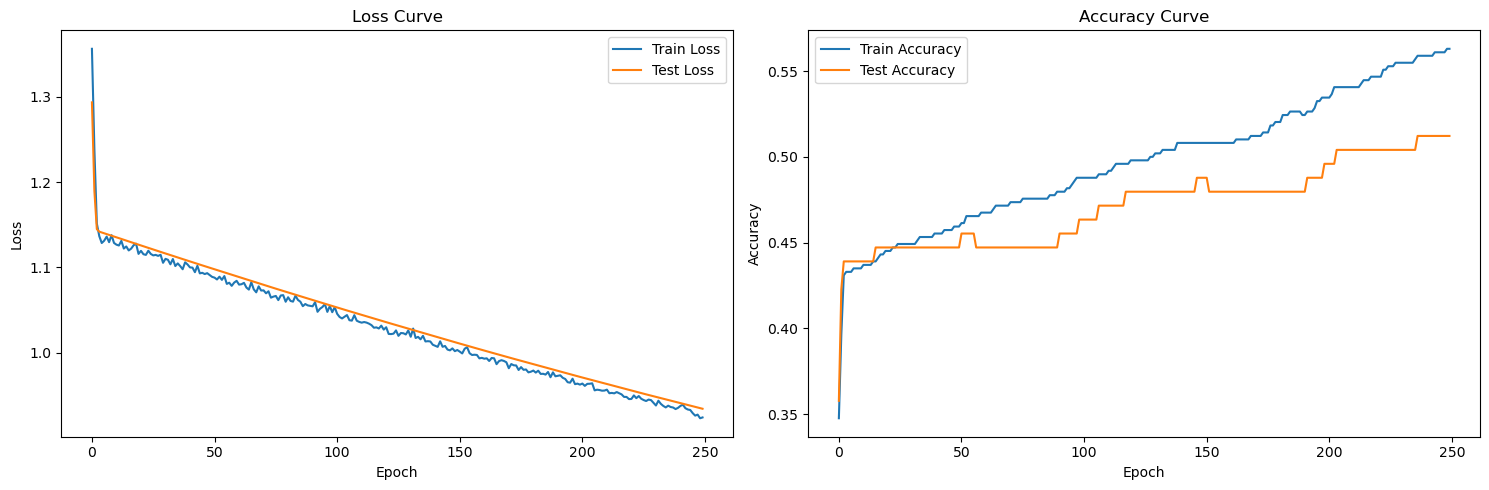

In [18]:
# Train the logistic regression model
# Example usage:
best_acc_model, best_loss_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=3,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=250
)
#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


In [19]:
logreg_model= best_loss_model
logreg_model


LogisticRegression(
  (linear): Linear(in_features=512, out_features=3, bias=True)
)

# Train the logistic regression model
# Example usage:
best_acc_model, best_loss_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=100
)
#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


# Save the best models by accuracy and loss
torch.save(best_acc_model.state_dict(), "best_acc_model.pth")
torch.save(best_loss_model.state_dict(), "best_loss_model.pth")


# 512= feature_dim = train_feats_simclr.tensors[0].shape[1] =  before projection head

# Save model state_dict
torch.save(logreg_model.state_dict(), "logreg_model_best.pth")


Extracting Features: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]


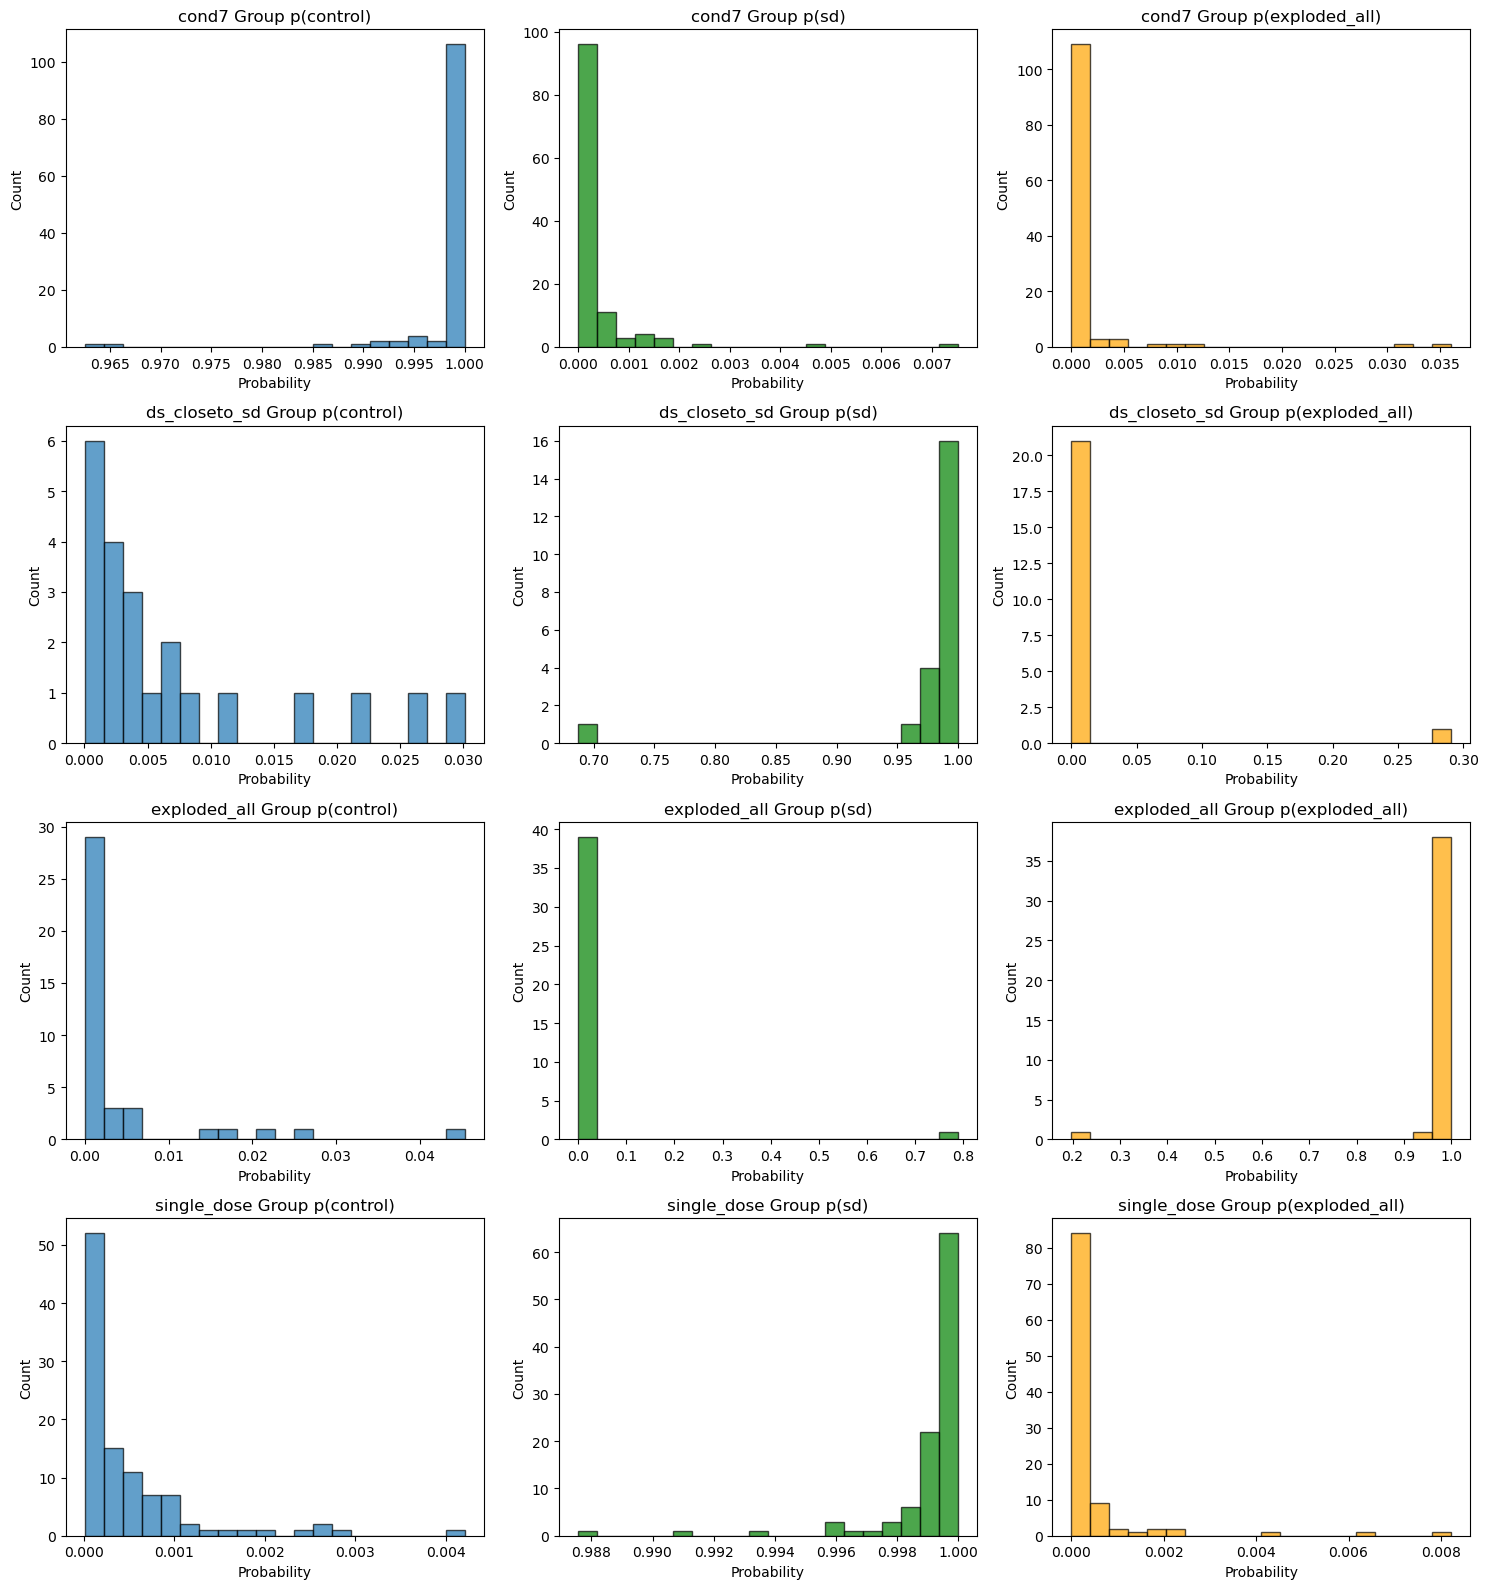

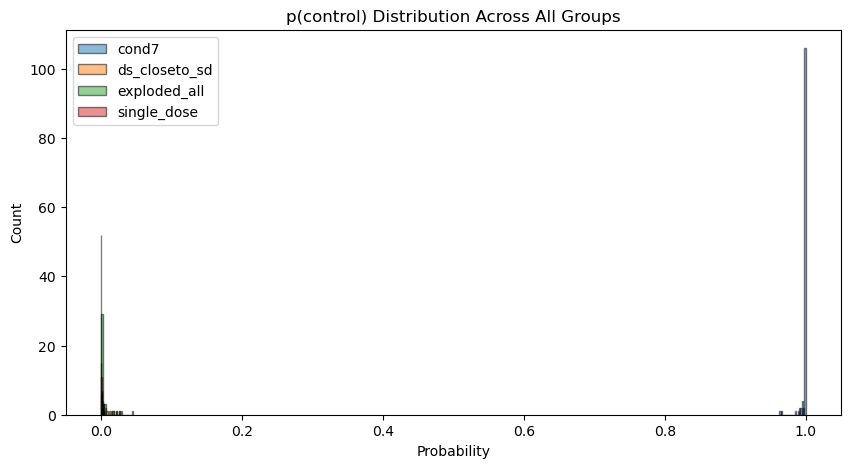

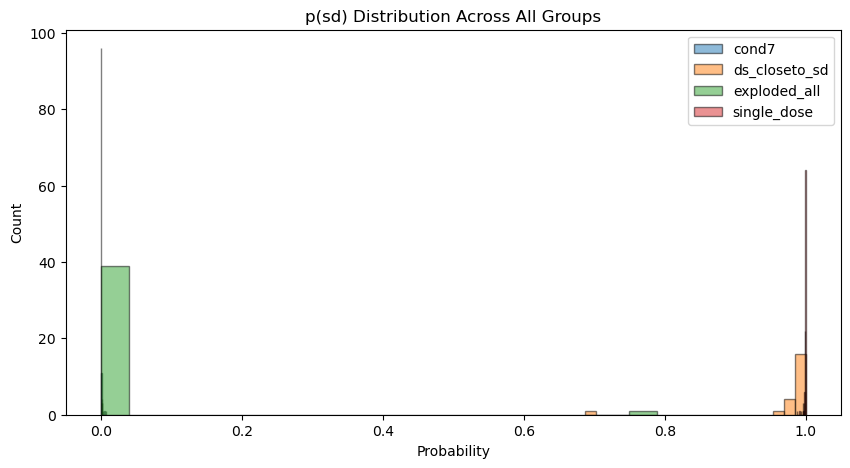

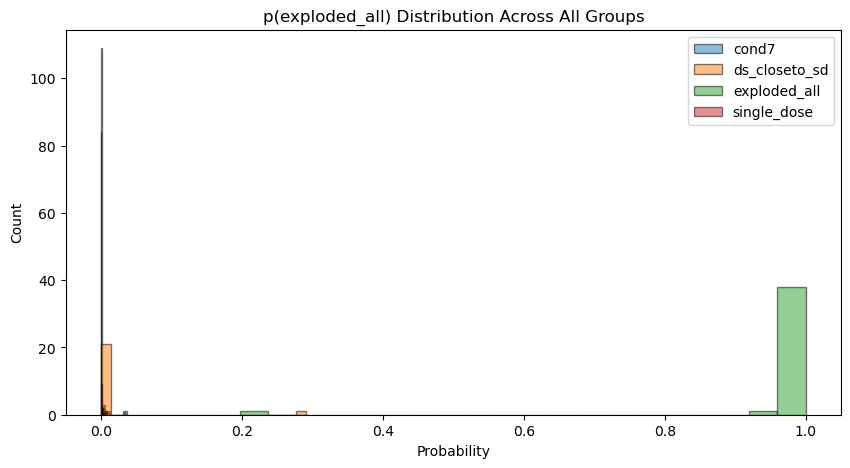

In [20]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for (control, sd, exploded_all) classification.
# device: torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # Dummy labels since it's just inference
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 3]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 3]
# probs[:, 0] = p(control)
# probs[:, 1] = p(sd)
# probs[:, 2] = p(exploded_all)

# Store results by group
# groups_data[group_name] = list of [p_control, p_sd, p_exploded_all, img_path]
groups_data = {g: [] for g in groups}
for p_control, p_sd, p_explod, grp, path in zip(probs[:,0], probs[:,1], probs[:,2], group_names, inference_paths):
    groups_data[grp].append([p_control, p_sd, p_explod, path])

# --------------------
# PLOTTING INDIVIDUAL DISTRIBUTIONS PER GROUP
# Now we have 3 probabilities per image. We will plot 3 histograms per group.
# --------------------

num_groups = len(groups)
# We need 3 subplots per group row now
fig, axs = plt.subplots(num_groups, 3, figsize=(15, 4*num_groups))

if num_groups == 1:
    axs = np.array([axs])  # Ensure axs is 2D even for a single group

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_sd_list = [item[1] for item in groups_data[grp]]
    p_explod_list = [item[2] for item in groups_data[grp]]

    # Plot p(control)
    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    # Plot p(sd)
    axs[i, 1].hist(p_sd_list, bins=20, alpha=0.7, edgecolor='black', color='green')
    axs[i, 1].set_title(f"{grp} Group p(sd)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

    # Plot p(exploded_all)
    axs[i, 2].hist(p_explod_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 2].set_title(f"{grp} Group p(exploded_all)")
    axs[i, 2].set_xlabel("Probability")
    axs[i, 2].set_ylabel("Count")

plt.tight_layout()
plt.show()

# --------------------
# PLOTTING COMBINED DISTRIBUTIONS ACROSS ALL GROUPS
# For each class probability, we combine distributions of all groups
# --------------------

# Combined p(control)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Combined p(sd)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_sd_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_sd_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(sd) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Combined p(exploded_all)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_explod_list = [item[2] for item in groups_data[grp]]
    plt.hist(p_explod_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(exploded_all) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Done!


In [21]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_sd, p_explod, img_path]
    all_images_data.extend(groups_data[grp])

In [23]:
# Sort by p(control) in ascending order
all_images_data_pcontrol = sorted(all_images_data, key=lambda x: x[0])
sorted_by_control = [(entry[3], entry[0]) for entry in all_images_data_pcontrol]
print("Images sorted by p(control) in ascending order:")
for img_path, p_ctrl in sorted_by_control:
    print(f"{img_path}: {p_ctrl:.4f}")

print("\n" + "-"*50 + "\n")

Images sorted by p(control) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\exploded_all\ds61_g9_C10-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\exploded_all\ds61_g8_B11-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.09_Day10_B08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.10_Day10_E09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\exploded_all\ds61_g8_B09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.09_Day10_B09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.10_Day10_C10-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_B07

In [24]:
# Sort by p(sd) in ascending order
all_images_data_psd = sorted(all_images_data, key=lambda x: x[1])
sorted_by_sd = [(entry[3], entry[1]) for entry in all_images_data_psd]
print("Images sorted by p(sd) in ascending order:")
for img_path, p_sd in sorted_by_sd:
    print(f"{img_path}: {p_sd:.4f}")

Images sorted by p(sd) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_D09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_D03-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_E10-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_G08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_C05-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_B05-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softma

In [25]:
# Sort by p(exploded_all) in ascending order
all_images_data_pexplod = sorted(all_images_data, key=lambda x: x[2])
sorted_by_explod = [(entry[3], entry[2]) for entry in all_images_data_pexplod]
print("Images sorted by p(exploded_all) in ascending order:")
for img_path, p_explod in sorted_by_explod:
    print(f"{img_path}: {p_explod:.4f}")

Images sorted by p(exploded_all) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_G08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.10_Day10_E09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_D09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBT_01.04_Day7_E10-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.09_Day10_B09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_B08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F08-T01.tiff: 0.0000
C:\Users\k54

In [22]:

# 750 epoch result, plot 2 is better.


Extracting Features: 100%|██████████| 18/18 [00:12<00:00,  1.41it/s]


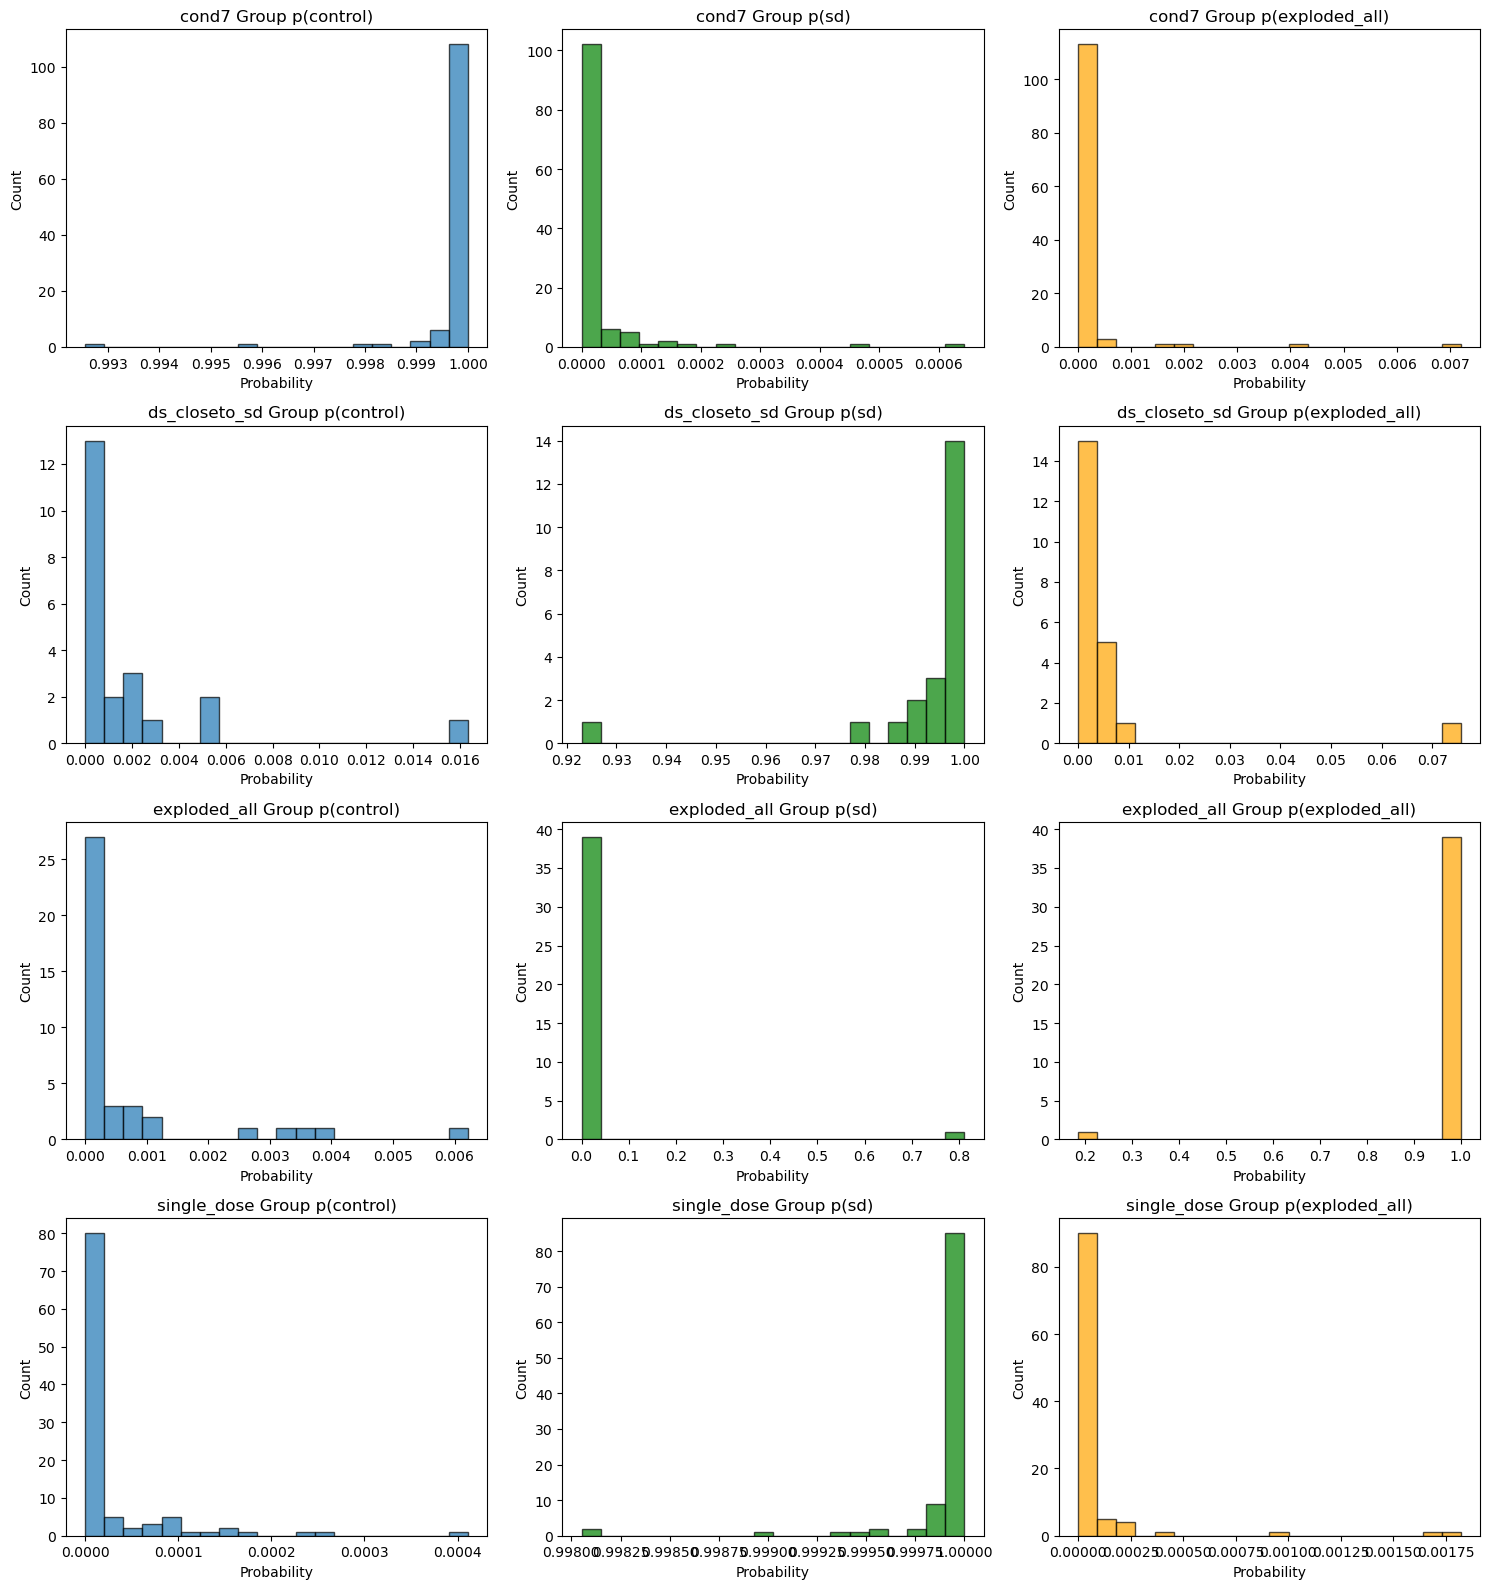

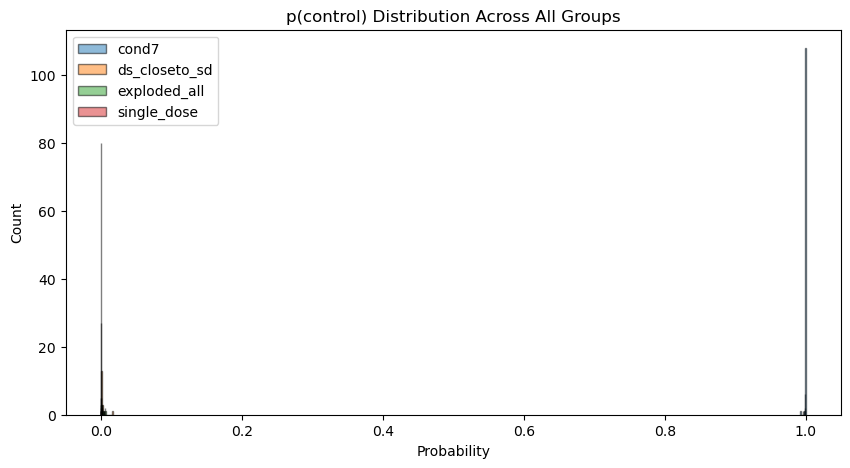

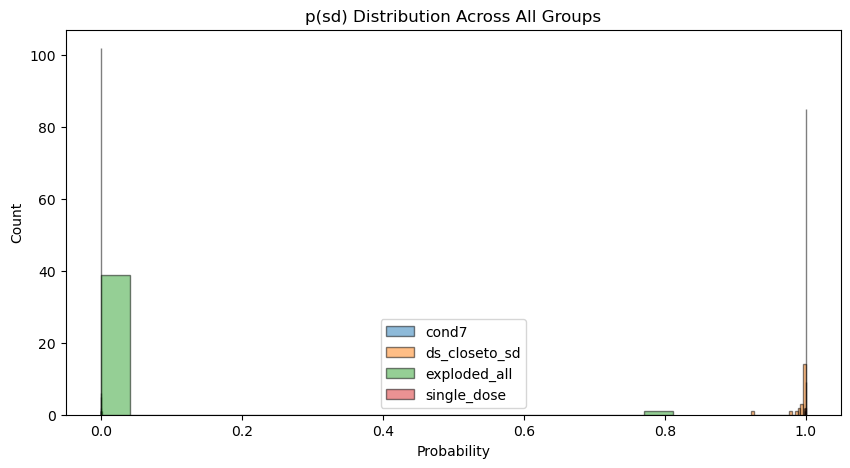

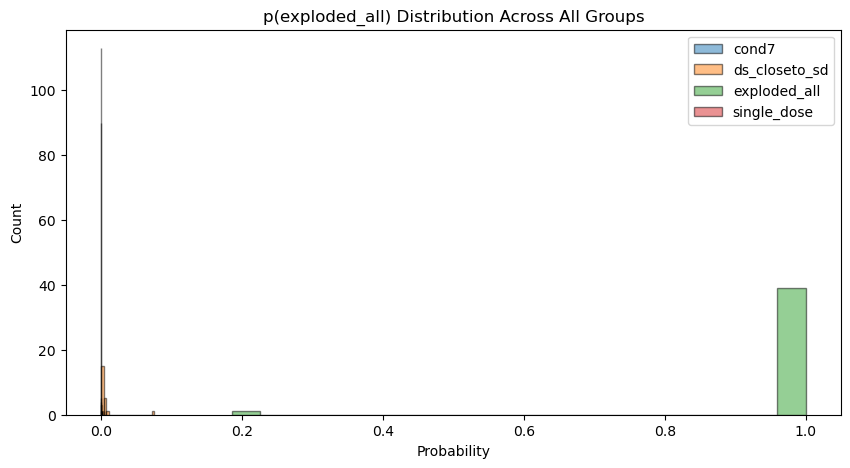

In [23]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for (control, sd, exploded_all) classification.
# device: torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # Dummy labels since it's just inference
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 3]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 3]
# probs[:, 0] = p(control)
# probs[:, 1] = p(sd)
# probs[:, 2] = p(exploded_all)

# Store results by group
# groups_data[group_name] = list of [p_control, p_sd, p_exploded_all, img_path]
groups_data = {g: [] for g in groups}
for p_control, p_sd, p_explod, grp, path in zip(probs[:,0], probs[:,1], probs[:,2], group_names, inference_paths):
    groups_data[grp].append([p_control, p_sd, p_explod, path])

# --------------------
# PLOTTING INDIVIDUAL DISTRIBUTIONS PER GROUP
# Now we have 3 probabilities per image. We will plot 3 histograms per group.
# --------------------

num_groups = len(groups)
# We need 3 subplots per group row now
fig, axs = plt.subplots(num_groups, 3, figsize=(15, 4*num_groups))

if num_groups == 1:
    axs = np.array([axs])  # Ensure axs is 2D even for a single group

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_sd_list = [item[1] for item in groups_data[grp]]
    p_explod_list = [item[2] for item in groups_data[grp]]

    # Plot p(control)
    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    # Plot p(sd)
    axs[i, 1].hist(p_sd_list, bins=20, alpha=0.7, edgecolor='black', color='green')
    axs[i, 1].set_title(f"{grp} Group p(sd)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

    # Plot p(exploded_all)
    axs[i, 2].hist(p_explod_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 2].set_title(f"{grp} Group p(exploded_all)")
    axs[i, 2].set_xlabel("Probability")
    axs[i, 2].set_ylabel("Count")

plt.tight_layout()
plt.show()

# --------------------
# PLOTTING COMBINED DISTRIBUTIONS ACROSS ALL GROUPS
# For each class probability, we combine distributions of all groups
# --------------------

# Combined p(control)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Combined p(sd)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_sd_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_sd_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(sd) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Combined p(exploded_all)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_explod_list = [item[2] for item in groups_data[grp]]
    plt.hist(p_explod_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(exploded_all) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Done!


In [24]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_sd, p_explod, img_path]
    all_images_data.extend(groups_data[grp])

In [25]:
# Sort by p(control) in ascending order
all_images_data_pcontrol = sorted(all_images_data, key=lambda x: x[0])
sorted_by_control = [(entry[3], entry[0]) for entry in all_images_data_pcontrol]
print("Images sorted by p(control) in ascending order:")
for img_path, p_ctrl in sorted_by_control:
    print(f"{img_path}: {p_ctrl:.4f}")

print("\n" + "-"*50 + "\n")

Images sorted by p(control) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_B07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.10_Day10_E09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_B09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_B10-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.09_Day10_B08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_G11-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_G07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\sing

In [26]:
# Sort by p(sd) in ascending order
all_images_data_psd = sorted(all_images_data, key=lambda x: x[1])
sorted_by_sd = [(entry[3], entry[1]) for entry in all_images_data_psd]
print("Images sorted by p(sd) in ascending order:")
for img_path, p_sd in sorted_by_sd:
    print(f"{img_path}: {p_sd:.4f}")

Images sorted by p(sd) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_D09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_C05-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_D03-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBT_01.04_Day7_B07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBT_01.04_Day7_G05-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBT_01.04_Day7_D03-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\sof

In [27]:
# Sort by p(exploded_all) in ascending order
all_images_data_pexplod = sorted(all_images_data, key=lambda x: x[2])
sorted_by_explod = [(entry[3], entry[2]) for entry in all_images_data_pexplod]
print("Images sorted by p(exploded_all) in ascending order:")
for img_path, p_explod in sorted_by_explod:
    print(f"{img_path}: {p_explod:.4f}")

Images sorted by p(exploded_all) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.10_Day10_E09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.09_Day10_B09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.09_Day10_B08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_D09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBT_01.04_Day7_B08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_B10-T01.tif